In [43]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Prepare the data

In [44]:
# Read in the data
file_path = Path('Resources/Myopia.csv')
df = pd.read_csv(file_path)
df.head()

,AGE,SPHEQ,AL,ACD,LT,VCD,SPORTHR,READHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY,MYOPIC
0,6,-0.052,21.889999,3.690,3.498,14.70,45,8,0,0,10,34,1,1,1
1,6,0.608,22.379999,3.702,3.392,15.29,4,0,1,1,7,12,1,1,0
2,6,1.179,22.490000,3.462,3.514,15.52,14,0,2,0,10,14,0,0,0
3,6,0.525,22.200001,3.862,3.612,14.73,18,11,0,0,4,37,0,1,1
4,5,0.697,23.290001,3.676,3.454,16.16,14,0,0,0,4,4,1,0,0


In [45]:
# Remove the "MYOPIC" column from the dataset.
df = df.drop('MYOPIC', axis=1)
# Save the cleaned dataframe as a new csv file for future analysis
file_path = Path('Resources/cleaned_myopia.csv')
df.to_csv(file_path, index=False)

In [46]:
# Standardize the data using StandardScaler.
scaler = StandardScaler()

# Train the scaler with the data.
X_scaled = scaler.fit_transform(df)
print( X_scaled[0])

[-0.42021911 -1.3639169  -0.89286146  0.48378402 -0.28144315 -1.0197916
  4.1506609   1.69744958 -0.68931054 -0.67299591  0.18405806  0.49830393
  0.98713773  1.0032415 ]


### Apply Dimensionality Reduction

In [47]:
# Applying PCA to reduce dimensions to 90% of the explained variance. 

# Initialize PCA model
pca =PCA(n_components=0.90)

# Get principal components of the data. 
myopia_pca = pca.fit_transform(X_scaled)
myopia_pca.shape

(618, 10)

In [48]:
# Get the explained variance ratio
pca.explained_variance_ratio_.sum()

0.9187361702915189

In [49]:
# Further reduce the dataset dimensions with t-SNE and visually inspect the results. 

# To do this, run t-SNE on the principal components, which is the output of the PCA transformation.
#Initialize the t-SNE model
tsne = TSNE(learning_rate=250, n_components=3, perplexity=50, verbose=1, n_iter=2500)
#Reduce dimensions
tsne_features = tsne.fit_transform(myopia_pca)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 618 samples in 0.037s...
[t-SNE] Computed neighbors for 618 samples in 0.103s...
[t-SNE] Computed conditional probabilities for sample 618 / 618
[t-SNE] Mean sigma: 1.438866
[t-SNE] KL divergence after 250 iterations with early exaggeration: 99.706909
[t-SNE] KL divergence after 2500 iterations: 2.061555


In [50]:
tsne_features.shape

(618, 3)

In [51]:
# Create a scatter plot of the t-SNE output. Are there distinct clusters?
plt.scatter(tsne_features[:,0],tsne_features[:,1],c=labels)

NameError: name 'labels' is not defined

### Perform a Cluster Analysis with K-means

In [38]:
# Identify best number of clusters using elbow curve
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(myopia_pca)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.head()

C:\Users\donna\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  f"KMeans is known to have a memory leak on Windows "


,k,inertia
0,1,7948.905345
1,2,6794.415695
2,3,6031.097742
3,4,5662.587617
4,5,5376.410589


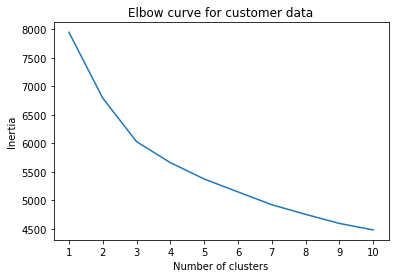

In [39]:
# Plot the elbow curve to find the best candidate(s) for k
plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve for customer data')
plt.show()

In [40]:
len(pca.components_)

10